# Calculating perplexity

A language model can be used to calculate the probability of a sequence of text. This is very useful for a number of applications, e.g. judging whether a word was likely mistyped and the corrected word makes more sense in the context.

These probability calculations can also be used to broadly evaluate a language model. A language model should give a higher probability to a real block of text compared to one that contains random words. The measure used in this context is known as **perplexity**. Let's figure out how to calculate it.
.

We'll define a span of text that we want to calculate the probability that the language model generated it.

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from scipy.special import softmax
import seaborn as sns
import matplotlib.pyplot as plt
from math import log

In [2]:
real_text = "It was the best of times, it was the worst of times"

In [3]:
tokenizer = AutoTokenizer.from_pretrained('distilgpt2')
model = AutoModelForCausalLM.from_pretrained('distilgpt2')

We want to calculate the probability of the sequence which would start with the word "It". So what probability does `distilgpt2` give for "It" starting a sequence? To find out that, we need to add the beginning of sequence (or bos) token at the beginning of the string. `distilgpt2` only had one special token (`<|endoftext|>`) that it uses to separate bits of text, whereas other models (e.g. BERT) do have specific tokens for the beginning of sequences (`[CLS]` for BERT). We'll add GPT's special token at the beginning of this sequence.

In [4]:
bos_token = tokenizer.special_tokens_map['bos_token']
real_text_with_bos = f"{bos_token} {real_text}"
real_text_with_bos

'<|endoftext|> It was the best of times, it was the worst of times'

In [5]:
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>'}

Now we tokenize it and get PyTorch tensors using `return_tensors='pt` so that it's ready to be inputted into the Transformer.

In [6]:
tokenized = tokenizer(real_text_with_bos, return_tensors='pt')
tokenized

{'input_ids': tensor([[50256,   632,   373,   262,  1266,   286,  1661,    11,   340,   373,
           262,  5290,   286,  1661]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

That gave us 14 tokens including the special token `<|endoftext|>` which has ID 50256.

We can now feed that tokenized text into the `distilgpt2` transformer model.

In [7]:
output = model(**tokenized)

In [8]:
logits = output.logits.detach().numpy()  # We use .detach().numpy() to convert the PyTorch tensor to a numpy array
logits.shape

(1, 14, 50257)

Scores for every possible token in our model (all 50257 of them) following each of the 14 input tokens. Recall that `len(tokenizer.vocab) = 50257`.

We also need to apply the softmax function as before to make the scores look like probabilities.

In [9]:
softmaxxed = softmax(logits,
                     axis=2)  # We use axis=2 so that the softmax is applied to each token's scores in turns and not all the values together

In [10]:
softmaxxed

array([[[5.25928044e-04, 6.18996797e-03, 6.68290886e-04, ...,
         8.87154794e-09, 8.95813024e-09, 1.19121652e-03],
        [2.23441675e-05, 8.64875346e-06, 1.17550644e-06, ...,
         1.54672863e-09, 5.26969927e-07, 1.13134070e-06],
        [3.83760307e-05, 1.00793468e-05, 2.06887151e-07, ...,
         1.37977985e-08, 4.95823372e-07, 8.98711107e-07],
        ...,
        [7.36748660e-03, 3.29770701e-05, 1.89666153e-07, ...,
         2.76013945e-09, 1.83644904e-08, 5.74342666e-05],
        [1.49164032e-06, 2.61427630e-07, 3.33100147e-09, ...,
         1.93665861e-09, 4.55775029e-10, 9.36747284e-08],
        [1.41671011e-02, 1.28783344e-04, 2.73045202e-06, ...,
         1.13483822e-09, 1.00380575e-08, 7.92555453e-04]]],
      shape=(1, 14, 50257), dtype=float32)

So what is the probability that `distilgpt2` gives to a text sequence beginning with "It"? Well, we need the token IDs from our sequence to figure this out. We can remove the first one as it is the special token `<|endoftext|>`.

In [11]:
token_ids = tokenized['input_ids'][0]
token_ids = token_ids[1:]
token_ids

tensor([ 632,  373,  262, 1266,  286, 1661,   11,  340,  373,  262, 5290,  286,
        1661])

In [12]:
tokenizer("It", return_tensors='pt')

{'input_ids': tensor([[1026]]), 'attention_mask': tensor([[1]])}

In [13]:
tokenizer(" It", return_tensors='pt')

{'input_ids': tensor([[632]]), 'attention_mask': tensor([[1]])}

In [14]:
len(token_ids), token_ids.shape

(13, torch.Size([13]))

"It" has token ID 632. To get the probability of that after the first token (which is the special beginning of sequence token), we can index into `softmaxxed`. We would set the first coordinate as 0 (as it's the first sequence of only one), the second coordinate as 0 (as it's after the first token) and then the third coordinate as 632 as that is the token ID for "It".

In [15]:
softmaxxed[0, 0, 632]

np.float32(0.0042890646)

A probability of 0.004, which is actually pretty high.

In [16]:
softmaxxed[:, :, 632].shape

(1, 14)

In [17]:
tokens = tokenizer.convert_ids_to_tokens(token_ids)

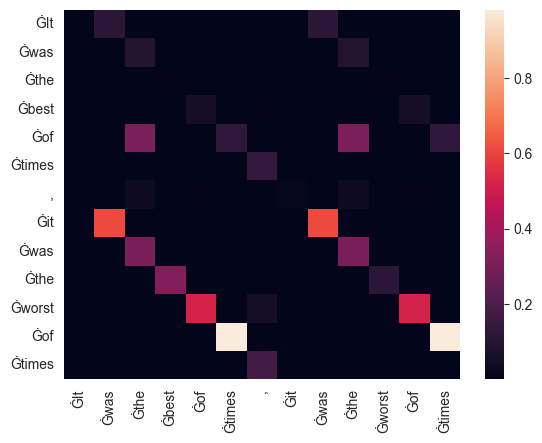

In [18]:
sns.heatmap(softmaxxed[:, 1:, :][:, :, token_ids].reshape(13, -1),
            xticklabels=tokens, yticklabels=tokens)
plt.show()

In [19]:
softmaxxed[0, 0, tokenizer.vocab['Ġmismatch']]

np.float32(4.88435e-09)

What's the probability starting with a rare word such as 'mismatch'? Note that we use the `Ġ` character to denote that the token is at the beginning of a word.

In [20]:
print(
    f"Probabilities of\n\t It:{softmaxxed[0, 0, 632]:.4f}\n\t mismatch:{softmaxxed[0, 0, tokenizer.vocab['Ġmismatch']]:.3e}")

Probabilities of
	 It:0.0043
	 mismatch:4.884e-09


As expected, that is much lower.

Practically, we often work with log probabilities as there are numerical problems when working with such tiny numbers. To calculate the probability of a sequence of tokens, we'd need to multiply together many probabilities which creates a tiny number. If we log-transform the probabilities, multiplication becomes addition and we can add the log probabilities together.

We'll use log base 2 for this. Let's get the log probability of "It" starting the sequence:

In [21]:
log(softmaxxed[0, 0, 632], 2)

-7.865121253967267

In [22]:
print(
    f"Soft max probability of 'It': {softmaxxed[0, 0, 632]:.4f}, vs log probability: {log(softmaxxed[0, 0, 632], 2):.4f}")

Soft max probability of 'It': 0.0043, vs log probability: -7.8651


Now we can get the probabilities out, can you calculate the log probability of the whole sequence? This involves adding up all the log probabilities, i.e. "It" (token ID=632) being after the first token, "was" (token ID=373) being after the second token, etc. The token IDs are available in `token_ids` and the [enumerate](https://docs.python.org/3/library/functions.html#enumerate) function may be helpful.

In [23]:
def get_log_probabilities(token_ids_, softmaxxed_):
    """
    Calculate the log probabilities of a sequence of token IDs.
    Args:
        token_ids_ (list): List of token IDs.
        softmaxxed_ (numpy.ndarray): Softmax probabilities for the tokens.
        
    Returns:
        float: Log probability of the sequence.
    """
    return sum(log(softmaxxed_[0, i, token_id], 2) for i, token_id in enumerate(token_ids_))

log_prob = get_log_probabilities(token_ids, softmaxxed)
log_prob

-44.53611226994318

You should have added up 13 log probabilities to get a sum of approximately `-44.5360`. We could use this to calculate the probability of the whole sequence, but we typically think about the probability averaged over the tokens. This makes it easier to compare different sequences that may have different lengths.

Divide the sum of log probabilities by the number of predicted tokens (13) to get the average log probability per token

In [24]:
log_prob/len(token_ids)

-3.4258547899956295

That should be approximately `-3.426`. Take that out of log space by calculating two to the power of that number.

In [25]:
def perplexity(token_ids_, softmaxxed_):
    """
    Calculate the perplexity of a sequence of token IDs.
    Args:
        token_ids_ (list): List of token IDs.
        softmaxxed_ (numpy.ndarray): Softmax probabilities for the tokens.
        
    Returns:
        float: Perplexity of the sequence.
    """
    return 2 ** (get_log_probabilities(token_ids_, softmaxxed_) / len(token_ids_))
text_1_perplexity = perplexity(token_ids, softmaxxed)
perplexity(token_ids, softmaxxed)

0.09304969360552243

This should be roughly `0.0931`. That's the average token probability of `distilgpt2` generating our input sequence. It's actually pretty high for a probability.

Dealing with these tiny numbers is tricky, so it is normal to take the reciprocal (1 over the value) to get the perplexity. Let's do that as the final step.

In [26]:
1/perplexity(token_ids, softmaxxed)

10.746945650776983

You should have a perplexity of roughly `10.7469`. Lower perplexity means that the language model was more likely to generate that text and was less "surprised" by the text. If there were any out-of-place tokens, the probability would be much lower, and hence the perplexity would be much higher.

Congratulations, you've worked through calculating one of the main metrics for examining language models. Typically this is done of very large samples of text to get a more accurate probability that can be used to compare language models.

# Extra

- Try recalculating perplexity for a span of text composed of random words (e.g. `highway dentist coffee surf table`). Does `distilgpt2` give it a higher or lower perplexity than our original input text? And what about perplexity?

In [29]:
text = "highway dentist coffee surf table"
text_with_bos = f"{bos_token} {text}"
text_tokenized = tokenizer(text_with_bos, return_tensors='pt')
tokenized_output = model(**text_tokenized)
softmaxxed = softmax(tokenized_output.logits.detach().numpy(), axis=2)
token_ids = text_tokenized['input_ids'][0]
token_ids = token_ids[1:]
text_perplexity = perplexity(token_ids, softmaxxed)
text_perplexity

3.8424609906796035e-06

In [31]:
print(f"Perplexity of random text: {text_perplexity}\nvs Perplexity of real text: {text_1_perplexity}")

Perplexity of random text: 3.8424609906796035e-06
vs Perplexity of real text: 0.09304969360552243


In [32]:
print(f"Inverse of perplexity of random text: {1/text_perplexity}\nvs Inverse of perplexity of real text: {1/text_1_perplexity}")

Inverse of perplexity of random text: 260249.87694751672
vs Inverse of perplexity of real text: 10.746945650776983
